In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from time import time, sleep
import json
import requests
import random
random.seed(11)
import datashop as ds
from datashop import report
import pprint as pp
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib as mpl
import os
import glob
from lxml import html
from matplotlib import cycler

from tqdm import tqdm
%matplotlib inline

In [48]:
class Feature:
    
    def __init__(self,series):
        
        self.series = series
        self.report = pd.Series()
        self.desc = self.series.describe()
        
        self.null_count = self.series.isna().sum()
        self.null_percent = round((self.null_count/len(self.series))*100,2)
        
        self.types = self.series.dropna().apply(
            lambda x: type(x).__name__)
        self.type_counts = self.types.value_counts()
        
        self.val_counts = self.series.value_counts()
        self.cat_ratio = len(self.val_counts)/len(self.series)
        self.threshold = 0.20           
            
        self.report['Length'] = len(self.series)
        self.report['Values'] = self.series.count()
        self.report['Missing']= str(self.null_count) +'({})%'.format(self.null_percent)
        self.report['Unique'] = len(self.val_counts)
        
        self.fig = plt.figure(figsize=(12,12))
        
        
        self.type_map = {
            'str':self.StringFeature,
            'int':self.NumericFeature,
            'float':self.NumericFeature,
            'datetime64':self.DateFeature,
            'datetime32':self.DateFeature,
            'category':self.Categorical
        }
        
        if len(self.type_counts) > 1:
            self.Categorical()
        elif isinstance(
            self.series.index,pd.core.indexes.datetimes.DatetimeIndex):
            self.DateFeature()
        else:
            self.type_map[str(self.type_counts.index[0])]()
        
        
        if self.cat_ratio < self.threshold:
            self.cat_msg = '\
                This feature looks like it might be categorical.\n \
                The ratio of unique values to total items \n \
                is greater than the specified threshold. \n \n \
                To convert to a categorical, call .categorical method.'
            
            print(self.cat_msg)        
            
    def NumericFeature(self):
        
        self.report['Mean'] = self.series.mean()
        self.report['Median'] = self.series.median()
       
        self.grid = plt.GridSpec(12,12,wspace=0.8,hspace=2)
        
        self.box_plot(self.series,self.grid[:2,:])
        self.histo(self.series,self.grid[2:,:])
        
    def StringFeature(self):
        
        self.str_lengths = self.series.fillna('').apply(len)
        
        self.report['Mean Length'] = self.str_lengths.mean()
        self.report['Median Length'] = self.str_lengths.median()
        
        self.chart_words = 25
        self.countvec = CountVectorizer(stop_words='english')
        self.wordcounts= self.countvec.fit_transform(self.series)
        self.word_totals = self.wordcounts.toarray().sum(axis=0)
        self.words = self.countvec.get_feature_names()
        self.count_dict = dict(zip(self.words,self.word_totals))
        self.count_series = pd.Series(self.count_dict)
        self.count_series.sort_values(ascending = False,inplace=True)
        
         
        self.fig.set_figheight(16)
        self.grid = plt.GridSpec(16,12,wspace=0.6,hspace=1)
        
        self.box_plot(self.str_lengths,self.grid[:2,:])
        self.histo(self.str_lengths,self.grid[2:9,:])
        self.bar_plot(self.count_series.head(self.chart_words),self.grid[9:,:])
      
    def DateFeature(self):
        
        self.series.sort_index(ascending=True,inplace=True)
        
        self.report["Earliest Point"] = self.series.index[0]
        self.report["Latest Point"] = self.series.index[-1]
        
        self.series.sort_index(ascending=True,inplace=True)
        
        self.time_plot = self.fig.add_subplot()    
        self.fig.set_figheight(5)
        self.fig.set_figwidth(16)
        
        self.time_plot.plot(self.series)
    
    def Categorical(self):
        
        display(self.report)
        
        self.series = self.series.astype('category')
        
        self.fig = plt.figure()
        self.fig.set_figheight(5)
        self.fig.set_figwidth(.75*len(self.val_counts))
        
        self.grid = plt.GridSpec(12,12,wspace=0.6,hspace=1)
        
        self.bar_plot(self.val_counts,self.grid[:,:])
        
    def bar_plot(self,series,grid_loc):
        
        self.bar_chart = self.fig.add_subplot(grid_loc)
        self.bar_chart.bar(
            list(series.index),
            series,
            width=0.7)
        self.bar_chart.tick_params(
                    axis='x', 
                    labelrotation=55,
                    length=10,
                    labelsize= 10
                    )
        
    def box_plot(self,series,grid_loc):
        
        self.box_axes = self.fig.add_subplot(grid_loc)
        self.box_axes.boxplot(series,vert=False)
        
    def line_plot(self,series,grid_loc):
        
        self.line_axes = self.fig.add_subplot(grid_loc)
        self.line_axes.plot(series)
    
    def histo(self,series,grid_loc):

        self.histo = self.fig.add_subplot(grid_loc)
        self.n = self.histo.hist(series,bins=100)[0]
        
        self.vert_marks = series.describe().loc[
            ['mean',
            '25%',
            '50%',
            '75%']
        ]
       
        self.histo.vlines(
            self.vert_marks,
            ymin=0,
            ymax=max(self.n) *1.2,
            linestyles='dashed')
        
        for index,value in self.vert_marks.items():
            
            self.histo.annotate(
                index,
                (value,max(self.n) *.9)
            )

In [77]:
cat_string = pd.read_csv('data/categ_string_sample').iloc[:,1]

norm_num = pd.read_csv('data/normal_numeric_sample').iloc[:,1]

time_ser = pd.read_csv('data/date_series_sample')
time_ser['Date'] = pd.to_datetime(time_ser['Date'])
time_ser.set_index('Date',inplace=True)
time_ser = time_ser.iloc[:,0]

C:\Users\umark\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Length        3000
Values        3000
Missing    0(0.0)%
Unique        3000
Mean       350.269
Median     349.535
dtype: object

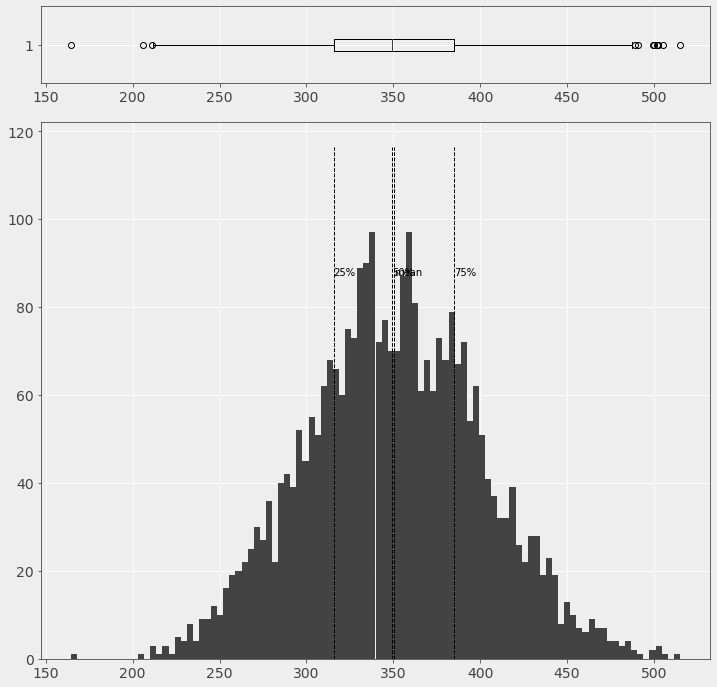

In [50]:
num_Test = Feature(norm_num)
num_Test.report

C:\Users\umark\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Length                           8762
Values                           8762
Missing                       0(0.0)%
Unique                           4891
Earliest Point    1986-01-02 00:00:00
Latest Point      2020-09-22 00:00:00
dtype: object

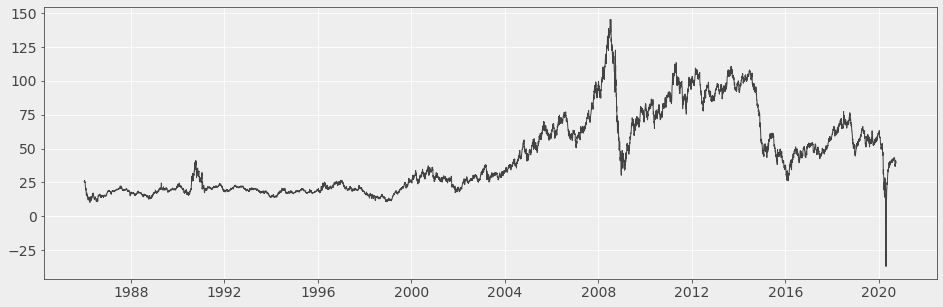

In [79]:
time_test = Feature(time_ser)
time_test.report

In [ ]:
self.type_map = {
            'str':{
                'method':self.StringFeature,
                'plots':self.
            }
            'int':self.NumericFeature,
            'float':self.NumericFeature,
            'datetime64':self.DateFeature,
            'datetime32':self.DateFeature,
            'category':self.Categorical
        }

In [83]:
plot_map =  {

'string': {
    'figure':{
        'figsize':[16,12],
        'grid_size':[12,12]
        },
    'plots':[
        {
        'type':self.box_plot,
        'data':self.str_lengths,
        'location':[:2,:]
        },
        {
        'type':self.histo,
        'data':self.str_lengths,
        'location':[2:9,:]
        },
        {
        'type':self.bar_plot,
        'data':self.count_series.head(self.chart_words),
        'location':[9:,:]
        }
    ]
    },
'numeric':{
    'figure':{
        'figsize':[12,12]
        'grid_size':[12,12]
                },
    'plots':[
        {
        'type':self.box_plot,
        'data':self.series,
        'location':[:2,:]
        },
        {
        'type':self.histo,
        'data':self.series,
        'location':[2:9,:]
        }
    ]
                    },

'categorical':{
    'figure':{
            'figsize':[12,.75*len(self.val_counts)]
            'grid_size':[12,12]
            },
    'plots':[
        {
        'type':self.box_plot,
        'data':self.series,
        'location':[:2,:]
        }
            ]

    }
}


SyntaxError: invalid syntax (<ipython-input-83-8e3d8a5d9f38>, line 12)

In [ ]:
def plotting:
    self.plot_dict = self.plot_map[self.feat_type]
    
    self.fig = plt.figure(figsize=(*self.plot_dict['figure']['figsize']))
    
    self.fig.set_figwidth(.75*len(self.val_counts))

ToDo

Time series
Categorical
show unique values in report
Outlier report

